### attenuation experiments

using attenuation effects with point clouds 

see https://github.com/chrishavlin/yt/tree/attenuate_effect


### 1. create a test function, display with matplotlib

In [1]:
import yt
import numpy as np


/home/chavlin/src/yt/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/chavlin/.config/yt/ytrc is deprecated in favor of /home/chavlin/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0 . This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [2]:
def get_test_func(nx = 40, ny=50, xlims=[0,1], ylims=[0,1],c1=0.3, c2 = 0.7):
    x = np.linspace(xlims[0],xlims[1],nx)
    y = np.linspace(ylims[0],ylims[1],ny)
    x,y = np.meshgrid(x,y)
    z = 3*np.exp(-(x - c1)**2/0.05) * np.exp(-(y - c1)**2/0.05)

    z += 5 * np.exp(-(x - c2)**2/0.05) * np.exp(-(y - c2)**2/0.05)

    R = (z - z.min())/(z.max()-z.min())
    G = np.zeros(R.shape) 
    B = 1 - R
    a = np.ones(R.shape)
    C = np.stack([R,G,B,a],axis=-1)
    return x,y,z,C

x,y,z,C = get_test_func()

In [3]:
C.shape

(50, 40, 4)

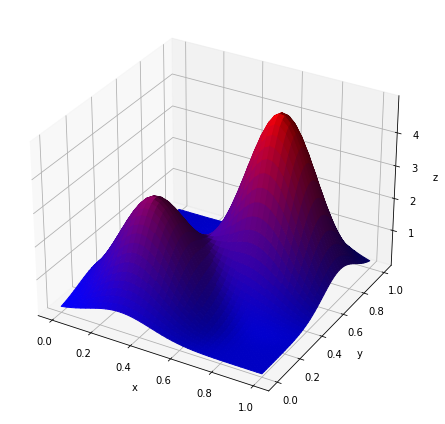

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6),
                       subplot_kw={'projection': '3d'})


ax.plot_surface(x, y, z, facecolors=C, rstride=1, cstride=1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
plt.show()

### 2. yt display

plot the surface as a point cloud! Two steps:
* create a uniform grid object to use for initializing the scene (easier cause of units registry issue)
* add the surface as opaque point objects

attenuation implementation only applies to the opaque objects. 


In [5]:
x,y,z,C = get_test_func(nx=500, ny=500,xlims=[-2,2], ylims=[-2,2],c1 = -0.5)
coords = np.column_stack([x.ravel(),y.ravel(),z.ravel()])
cvals = C.reshape((coords.shape[0],4))

In [6]:
bbox = np.array([[-2,2],[-2,2],[0,10]])
fake_shape = (50, 50, 50)
fake_field = np.ones(fake_shape)
data = dict(field_1 = (fake_field, "m"))
ds_u = yt.load_uniform_grid(data, fake_shape,bbox=bbox,length_unit='m')

yt : [INFO     ] 2021-03-30 18:03:16,086 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-03-30 18:03:16,087 Parameters: domain_dimensions         = [50 50 50]
yt : [INFO     ] 2021-03-30 18:03:16,087 Parameters: domain_left_edge          = [-2. -2.  0.]
yt : [INFO     ] 2021-03-30 18:03:16,087 Parameters: domain_right_edge         = [ 2.  2. 10.]
yt : [INFO     ] 2021-03-30 18:03:16,088 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2021-03-30 18:03:16,272 Rendering scene (Can take a while).
yt : [INFO     ] 2021-03-30 18:03:18,715 Creating volume
yt : [INFO     ] 2021-03-30 18:03:18,723 Creating transfer function
yt : [INFO     ] 2021-03-30 18:03:18,724 Calculating data bounds. This may take a while. Set the TransferFunctionHelper.bounds to avoid this.
/home/chavlin/src/yt/yt/visualization/volume_rendering/transfer_functions.py:731: RuntimeWarning: invalid value encountered in double_scalars
  rel = (v - self.x_bounds[0]) / (self.x_bounds[1] - self.x_bounds[0])


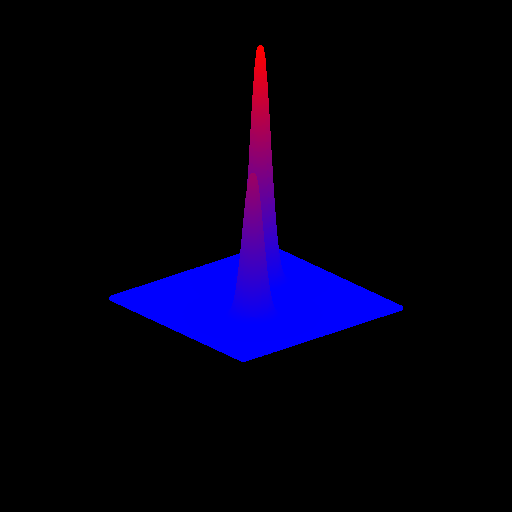

In [7]:
sc = yt.create_scene(ds_u,field='field_1')
sc.add_camera()
cam = sc.get_camera()
pos = cam.get_position()
pos[2]=-pos[2]*0.5
cam.set_position(pos,north_vector=[0,0,1])
cam.set_focus([0.,0.,.1])
cam.rotate(-5*np.pi/180., rot_vector=ds_u.arr([0,0,1],""))

# add all the points
pts = yt.visualization.volume_rendering.render_source.PointSource(coords, colors=cvals, radii=2)
sc.add_source(pts)

yt : [INFO     ] 2021-03-30 18:03:18,974 Rendering scene (Can take a while).
yt : [INFO     ] 2021-03-30 18:03:21,486 Creating volume
yt : [INFO     ] 2021-03-30 18:03:21,491 Creating transfer function
yt : [INFO     ] 2021-03-30 18:03:21,492 Calculating data bounds. This may take a while. Set the TransferFunctionHelper.bounds to avoid this.


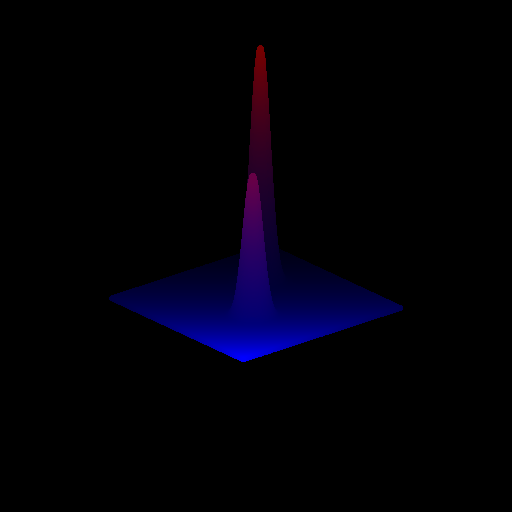

In [8]:
sc = yt.create_scene(ds_u,field='field_1')
sc.add_camera()
sc.add_attenuation()

cam = sc.get_camera()
pos = cam.get_position()
pos[2]=-pos[2]*0.5
cam.set_position(pos,north_vector=[0,0,1])
cam.set_focus([0.,0.,0.1])
# cam.width = cam.width*7.
cam.rotate(-5*np.pi/180., rot_vector=ds_u.arr([0,0,1],""))
pts = yt.visualization.volume_rendering.render_source.PointSource(coords, colors=cvals, radii=2)
sc.add_source(pts)

clearer effect with a single rgb value: 

yt : [INFO     ] 2021-03-30 18:03:21,733 Rendering scene (Can take a while).
yt : [INFO     ] 2021-03-30 18:03:24,171 Creating volume
yt : [INFO     ] 2021-03-30 18:03:24,176 Creating transfer function
yt : [INFO     ] 2021-03-30 18:03:24,176 Calculating data bounds. This may take a while. Set the TransferFunctionHelper.bounds to avoid this.


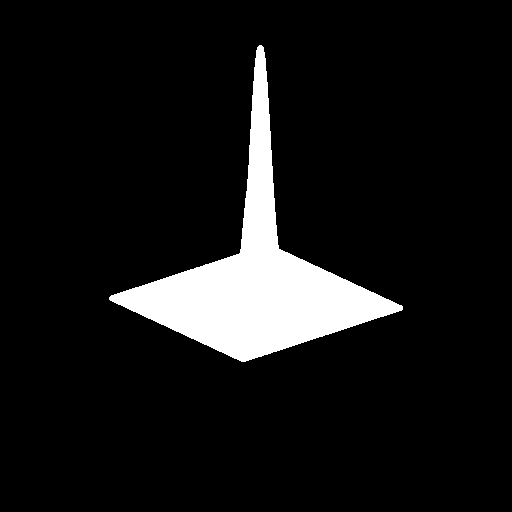

In [9]:
sc = yt.create_scene(ds_u,field='field_1')
sc.add_camera()
cam = sc.get_camera()
pos = cam.get_position()
pos[2]=-pos[2]*0.5
cam.set_position(pos,north_vector=[0,0,1])
cam.set_focus([0.,0.,.1])
# cam.width = cam.width*7.
cam.rotate(-5*np.pi/180., rot_vector=ds_u.arr([0,0,1],""))
cvals = np.ones(cvals.shape)
pts = yt.visualization.volume_rendering.render_source.PointSource(coords, colors=cvals, radii=2)
sc.add_source(pts)
sc.show()

yt : [INFO     ] 2021-03-30 18:03:24,377 Rendering scene (Can take a while).


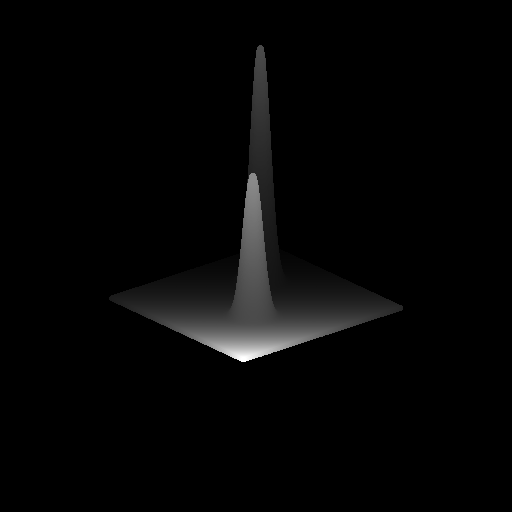

In [10]:
sc.add_attenuation(att_fac=0.8)
sc.render()
sc.show()

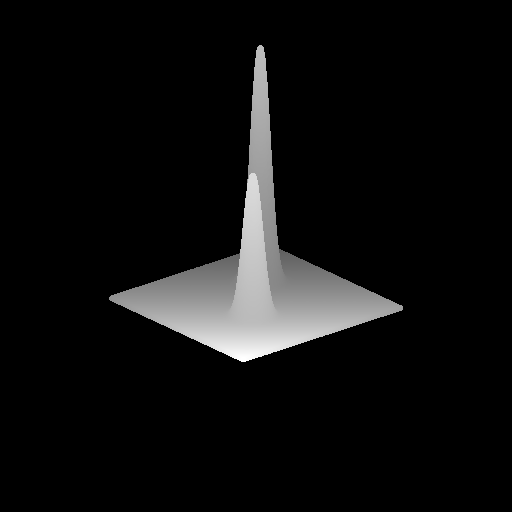

In [11]:
sc.clear_effects()
sc.add_attenuation(att_fac=0.2)
sc.render()
sc.show()

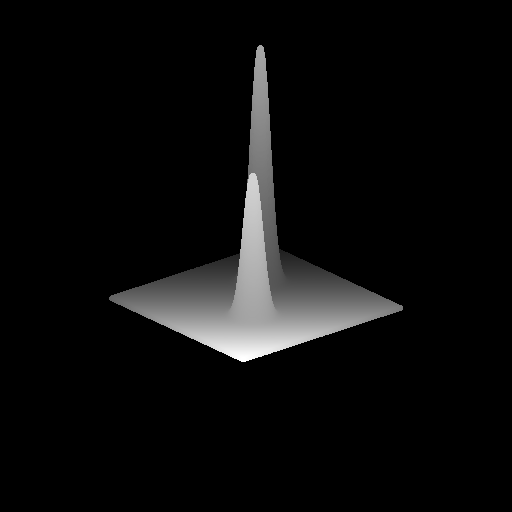

In [12]:
sc.clear_effects()
sc.add_attenuation(att_fac=0.2, method='exp2')
sc.render()
sc.show()

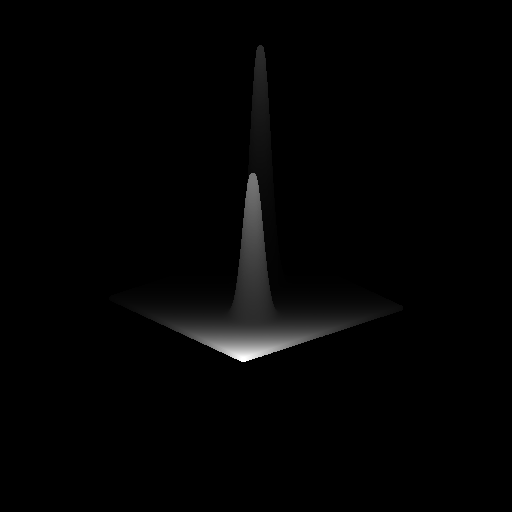

In [13]:
sc.clear_effects()
sc.add_attenuation(att_fac=0.4, method='exp2')
sc.render()
sc.show()

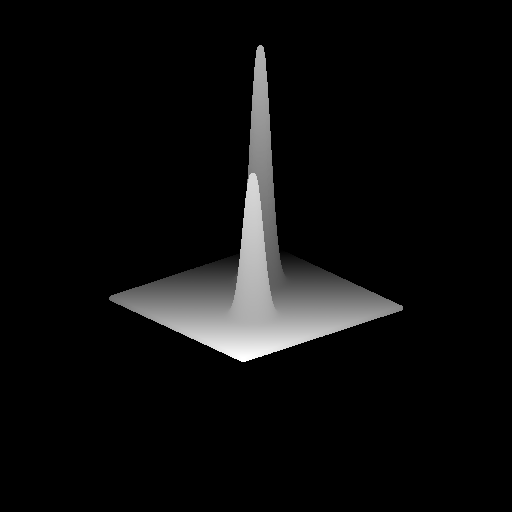

In [14]:
sc.clear_effects()
sc.add_attenuation(method='linear')
sc.render()
sc.show()

left: no attenuation, right: with attenuation (exponential, factor 0.2), slightly different surface
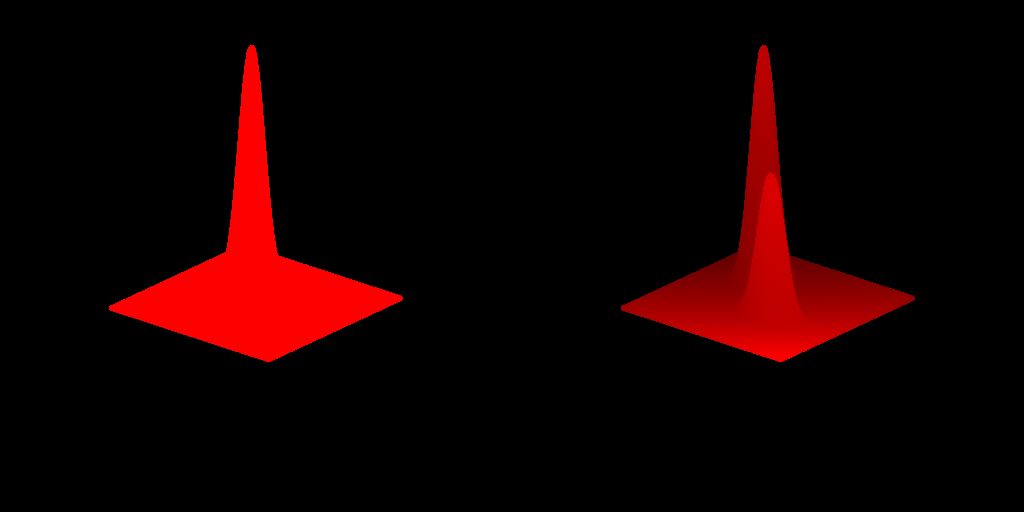
